In [4]:
%matplotlib inline
from __future__ import division
import numpy as np

import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import networkx as nx
from djPyi2 import mpltools
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import matplotlib.patches as patches
from djPyi2 import Common as CM
import matplotlib.image as mpimg

import numpy as np
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as mpatch

import matplotlib.transforms as mtransforms

In [128]:
reload(mpltools)

<module 'djPyi2.mpltools' from '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/djPyi2/djPyi2/mpltools.py'>

In [5]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

In [6]:
dy_name = 'Figures'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

In [1]:
def fix_svlen(info_all):
    
    info_all = info_all.copy()
    info_all['SVLEN_MOD'] = info_all.SVLEN
    inds = info_all[info_all.SVTYPE_NR == 'STR'].index.tolist()
    info_all.loc[inds, 'SVLEN_MOD'] = info_all.loc[inds, 'MAX_ALLELE_CHANGE']
    info_all['log10_SVLEN_MOD'] = info_all['SVLEN_MOD'] 
    inds = info_all[(info_all.is_SVLEN == True) | (info_all.SVTYPE == 'INV')].index.tolist()
    info_all.loc[inds, 'log10_SVLEN_MOD'] = np.log10(info_all.loc[inds, 'SVLEN_MOD'].astype(float))
    return info_all

In [8]:
def plot_corr(info_novelty_dd, ax, c1, c2, pal, gb = 'SVTYPE_NR', size = 10, fontsize = 8, **kwargs):
    tdf_corr_plot = info_novelty_dd[(info_novelty_dd[c1] > 0) & (info_novelty_dd[c2] > 0)]
    tdf_corr = tdf_corr_plot[[c1, c2]].applymap(float)
    pear_corr = tdf_corr[[c1, c2]].corr().iloc[0,1]
    ax.grid(zorder = 0)
    ax = plot_scatter_in_categories(tdf_corr_plot, c1, c2, ax, gb = 'SVTYPE_NR', pal=pal, 
                                    pearson_corr=False, size = size, zorder = 20)


    ax = sns.regplot(x = c1, y = c2, data = tdf_corr,color = 'black', scatter = False, ax = ax, 
                     line_kws={'zorder':22, 'lw': 0.8})

    annotation = '$r=$ {}'.format(round(pear_corr, 3), zorder = 25)
    ax.text(1, 1, annotation, fontsize = fontsize, transform = ax.transAxes,
                    horizontalalignment='right',  verticalalignment='bottom')
    return ax

In [7]:
def plot_scatter_in_categories(df, x, y, ax, size = 10,  pal = False, gb = False, pearson_corr=False, **kwargs):
    if gb != False:
        for c, d in df.groupby(gb):
            if type(pal) != bool:
                ax.scatter(d[x], d[y], color = pal[c], s = size, label = c, **kwargs)
            else:
                ax.scatter(d[x], d[y], s = size, label = c, **kwargs)
    else:
        ax.scatter(df[x], df[y], s = size, **kwargs)
        
    ax.set(xlabel = x, ylabel=y)
    if pearson_corr:
        tdf = df[[x,y]].applymap(float)
        
        corr_coef, p_val = stats.pearsonr(tdf[x], tdf[y])
        return ax, corr_coef, p_val
        
    return ax

In [9]:
info_pass = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/dosage_vcf_and_variant_info/info_pass_consented_annot_472.pkl')
info_pass = info_pass[~info_pass['CHROM'].isin(['X', 'Y'])]

info_novelty = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gtex_1kgp_intersection_analysis/matched_sv_1kgp_gtex_i2qtl_pass_472.pkl')

In [10]:
inds = info_pass.NR_ID.unique().tolist()
# just non redun vars
info_nr = info_pass.loc[inds]

In [11]:
info_nr = fix_svlen(info_nr)

In [12]:
info_novelty_filt = info_novelty[info_novelty.ID_i2QTL.isin(info_nr.ID.tolist())]
info_novelty_dd = info_novelty_filt.drop_duplicates(['ID_i2QTL'])
# vc_sb_vars = get_proportions_novel_nr_subset(info_novelty_dd)

In [41]:
bnd = info_novelty_filt[info_novelty_filt.NR_ID.isnull() == True].index
info_novelty_filt.loc[bnd, 'NR_ID'] = info_novelty_filt.loc[bnd, 'ID_i2QTL']

In [42]:
nref_kgp = info_novelty_filt.groupby('ID_i2QTL').NONREF_AF_1KGP.mean()
nref_gtex = info_novelty_filt.groupby('ID_i2QTL').NONREF_AF_GTEx.mean()
info_novelty_dd = info_novelty_filt.drop_duplicates(['ID_i2QTL'])
info_novelty_dd = info_novelty_dd.set_index('ID_i2QTL', drop=False)
info_novelty_dd['NONREF_AF_GTEx'] = nref_gtex
info_novelty_dd['NONREF_AF_1KGP'] = nref_kgp
info_novelty_dd[['NONREF_AF_GTEx', 'NONREF_AF_1KGP']] = info_novelty_dd[['NONREF_AF_GTEx', 
                                                                         'NONREF_AF_1KGP']].fillna(0.0)

In [45]:
mpl.gridspec.rcParams['legend.handletextpad'] = 0.3
mpl.gridspec.rcParams['legend.columnspacing'] = 0.5
mpl.gridspec.rcParams['legend.labelspacing'] = 0.5
mpl.gridspec.rcParams['axes.labelpad'] = 2
mpl.gridspec.rcParams['axes.titlesize'] = 7
mpl.gridspec.rcParams['axes.labelsize'] = 7
mpl.gridspec.rcParams['ytick.labelsize'] = 6
mpl.gridspec.rcParams['xtick.labelsize'] = 6
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'

In [44]:
color_pal_svtypes_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/color_pal_svtypes_all.pkl').to_dict()

In [17]:
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

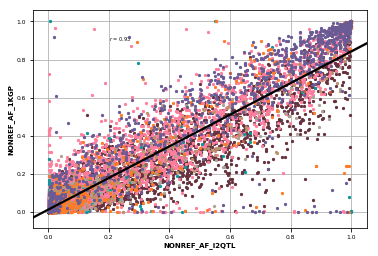

In [18]:
fig, ax = plt.subplots(1,1)
ax = plot_corr(info_novelty_dd, ax, 'NONREF_AF_i2QTL', 'NONREF_AF_1KGP', gb = 'SVTYPE_NR', 
                pal = color_pal_svtypes_all, size = 5, fontsize = 5)

In [18]:
order_var = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'ALU', 'LINE1', 'SVA', 'STR']

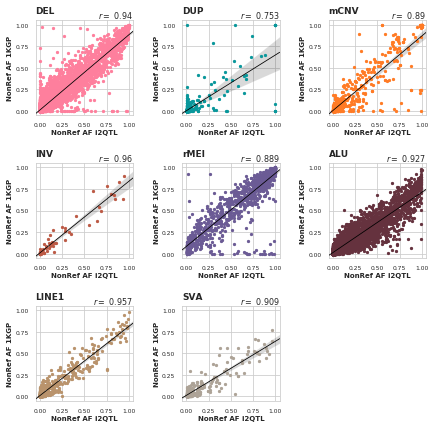

In [45]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(3,3, figsize = (7,7), gridspec_kw={'wspace' : 0.5, 'hspace' :0.5}, sharex = True,
                            sharey = True)
    
    
    ax = plot_corr(info_novelty_dd, ax, 'NONREF_AF_i2QTL', 'NONREF_AF_1KGP', gb = 'SVTYPE_NR', 
                pal = color_pal_svtypes_all, size = 5, fontsize = 5)
    
    af = axes.flat

    # af[0].get_shared_y_axes(af[0], af[2])

    bins = np.arange(0,8, 0.2)
    for ind, svt in enumerate(order_var[:-1]):
        ax = af[ind]
        tdf = info_novelty_dd[info_novelty_dd.SVTYPE_NR == svt]
        tdf = tdf[(tdf['NONREF_AF_i2QTL'] > 0) & (tdf['NONREF_AF_1KGP'] > 0)]
        
        ax = plot_corr(tdf, ax, 'NONREF_AF_i2QTL', 'NONREF_AF_1KGP', gb = 'SVTYPE_NR', 
                pal = color_pal_svtypes_all, size = 5, fontsize = 8)
        ax.xaxis.set_tick_params(which = 'both', labelbottom = True)
        ax.yaxis.set_tick_params(which = 'both', labelleft = True)
        
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlim(-0.05, 1.05)
        ticks = [0, 0.25, 0.5, 0.75, 1.0]
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.text(0,1.1, svt, fontsize = 9, transform = ax.transAxes,
                    horizontalalignment='left',  verticalalignment='center', weight = 'bold')
        ax.set(xlabel='NonRef AF i2QTL', ylabel='NonRef AF 1KGP')
    af[8].set_axis_off()
    
fig.savefig(os.path.join(private_out, 'SupFig_NREF_AF_VS_KGP'), dpi=500, bbox_inches='tight') 
    

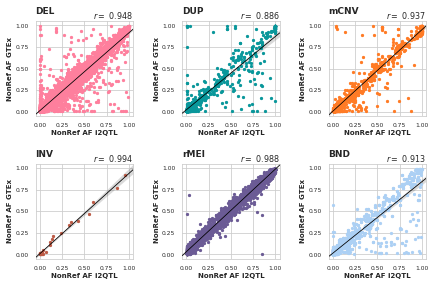

In [149]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(3,3, figsize = (7,7), gridspec_kw={'wspace' : 0.5, 'hspace' :0.5}, sharex = True,
                            sharey = True)
    
    
    ax = plot_corr(info_novelty_dd, ax, 'NONREF_AF_i2QTL', 'NONREF_AF_1KGP', gb = 'SVTYPE_NR', 
                pal = color_pal_svtypes_all, size = 5, fontsize = 5)
    
    af = axes.flat

    # af[0].get_shared_y_axes(af[0], af[2])

    bins = np.arange(0,8, 0.2)
    for ind, svt in enumerate(order_var[:-4] + ['BND']):
        ax = af[ind]
        tdf = info_novelty_dd[info_novelty_dd.SVTYPE_NR == svt]
        tdf = tdf[(tdf['NONREF_AF_i2QTL'] > 0) & (tdf['NONREF_AF_GTEx'] > 0)]
        
        ax = plot_corr(tdf, ax, 'NONREF_AF_i2QTL', 'NONREF_AF_GTEx', gb = 'SVTYPE_NR', 
                pal = color_pal_svtypes_all, size = 5, fontsize = 8)
        ax.xaxis.set_tick_params(which = 'both', labelbottom = True)
        ax.yaxis.set_tick_params(which = 'both', labelleft = True)
        
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlim(-0.05, 1.05)
        ticks = [0, 0.25, 0.5, 0.75, 1.0]
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.text(0,1.1, svt, fontsize = 9, transform = ax.transAxes,
                    horizontalalignment='left',  verticalalignment='center', weight = 'bold')
        ax.set(xlabel='NonRef AF i2QTL', ylabel='NonRef AF GTEx')
    for i in range(6,9):
        af[i].remove()
       
    
fig.savefig(os.path.join(private_out, 'SupFig_NREF_AF_VS_GTEx'), dpi=500, bbox_inches='tight') 
    

In [ ]:
ax.remove()

In [30]:
def get_rr_summary_sv(rr_all):
    rr_all['RR'] = rr_all['RR'].astype(float)
    rr_filt = rr_all[rr_all.id_col == 'Filtered']
    rr_unfilt = rr_all[~((rr_all.SVTYPE == 'STR') & (rr_all.id_col == 'Filtered'))]
    rr_filt['final_set']= rr_filt.final_set_per_caller
#     inds = rr_filt[rr_filt.SVTYPE== 'STR'].index.tolist()
#     rr_filt.loc[inds, 'final_set'] = True

    t1 = rr_filt[rr_filt.final_set].groupby(['SVTYPE_NR', 'CALLER']).RR.agg({'RR':'mean', 'stdev': 'std'})
    t1['stage'] = 'Filtered'
    t2 = rr_unfilt.groupby(['SVTYPE_NR', 'CALLER']).RR.agg({'RR':'mean', 'stdev': 'std'})
    t2['stage'] = 'Unfiltered'
    rr_summary = pd.concat([t1, t2]).reset_index()
    
#     t1 = rr_filt[rr_filt.final_set].groupby(['SVTYPE_NR', 'CALLER']).RR.std().to_frame('RR_std')
#     t1['stage'] = 'Filtered'
#     t2 = rr_unfilt.groupby(['SVTYPE_NR', 'CALLER']).RR.std().to_frame('RR_std')
#     t2['stage'] = 'Unfiltered'
#     rr_summary_std = pd.concat([t1, t2]).reset_index()
    
    return rr_summary, rr_filt, rr_unfilt

In [31]:
rr_summary, rr_filt, rr_unfilt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/dosage_vcf_and_variant_info/rr_all_callers_twins.pkl').pipe(get_rr_summary_sv)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [54]:
novel = info_novelty_filt[(info_novelty_filt.ID_GTEx.isnull() == False) | (info_novelty_filt.ID_1KGP.isnull() == False)].NR_ID.unique().tolist()

In [55]:
convert = {False:'Novel', True: 'Known'}
info_nr['novel'] = info_nr.NR_ID.isin(novel).apply(lambda x:convert[x])

In [56]:
rr_filt['novel'] = rr_filt.NR_ID.isin(novel).apply(lambda x:convert[x])

rr_filt_dd = rr_filt[rr_filt.final_set_per_caller==True]

In [57]:
colors_known_novel = {'Novel': (0.5529411764705883, 0.8980392156862745, 0.6313725490196078), 
                      'Known':    (0.5085736255286428, 0.5085736255286428, 0.5085736255286428)}

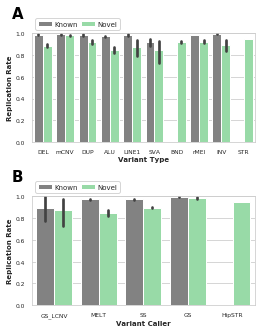

In [142]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(2,1, figsize = (4,5), gridspec_kw={'wspace' : 0.5, 'hspace' :0.5}, sharex = False,
                            sharey = True)
    
    ax1 = axes[0]
    ax2 = axes[1]
    
    ax1  = sns.barplot(x = 'SVTYPE_NR', y = 'RR', hue = 'novel', data = rr_filt_rr, 
                ax = ax1, palette=colors_known_novel)
    
    ax2 = sns.barplot(x = 'CALLER', y = 'RR', hue = 'novel', data = rr_filt_rr, 
                ax = ax2, palette=colors_known_novel)
    
    
    ax1.legend(bbox_to_anchor = (0,1), loc = 'lower left', ncol = 2, fontsize = 7)
    ax2.legend(bbox_to_anchor = (0,1), loc = 'lower left', ncol = 2, fontsize = 7)
    
    labels = ['A', 'B']
    for i, a in enumerate([ax1, ax2]):
        a.set_xlabel('')
        a.set_ylabel('Replication Rate')
        mpltools.label_offset_axes(a, fig, labels[i], x = -20, y = 15)
    ax1.set_xlabel('Variant Type')
    ax2.set_xlabel('Variant Caller')
    

fig.savefig(os.path.join(private_out, 'SupFig_Novelty_RR'), dpi=500, bbox_inches='tight') 
    

# Variant Novelty and Length

In [19]:
order_vars_all = ['DEL', 'DUP', 'mCNV', 'INV', 'BND','rMEI', 'ALU', 'LINE1', 'SVA', 'STR', 'INDEL DEL', 
              'INDEL INS', 'SNV']

In [20]:
order_sv_str = order_vars_all[:-3]

In [21]:
def format_easy_read_log(x, log10 = False, rounding = 1, ints = False):
    """ input list of tick locations, output formatted ticks 
    with bp,kbpb, MB annotations - log: if the ticks
    are log scaled- what base is the log scale 
    example: log=10 for log base 10"""
    if log10:
        input_ticks = [(10**i) for i in x]
    else:
        input_ticks = x    
    out = []
    for t in input_ticks: 
        if t < 1000:
            if not ints:
                f = copy.deepcopy(t)
            else:
                f = int(t)
        
        elif t > 100000:
            if not ints:
                f = "{}M".format(round((t/1000000), rounding))
            else:
                f = "{}M".format(int(round((t/1000000), rounding)))
            
        elif t >= 1000:
            if not ints:
                f = "{}K".format(round((t/1000), rounding))
            else:
                 f = "{}K".format(int(round((t/1000), rounding)))
            
        else:
            return 'missed case'
        out.append(f)
    
    return out


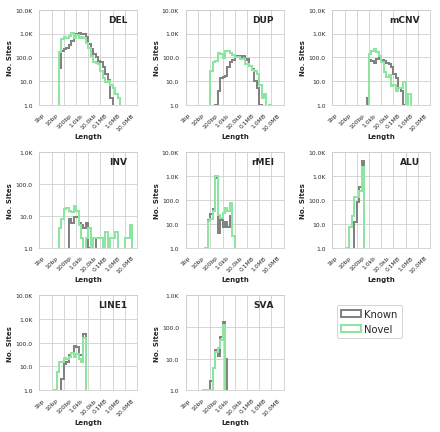

In [141]:
with sns.axes_style('whitegrid'):

    fig, axes = plt.subplots(3,3, figsize = (7,7), gridspec_kw={'wspace' : 0.5, 'hspace' :0.5})
    # gs = mpl.gridspec.GridSpec(4, 4, 
    #                            figure =fig,
    #                            width_ratios=[1, 1], height_ratios = [0.8, 1, 0.8, 0.8], wspace = 0.5, hspace=0)

    orders = [['DEL', 'DUP', 'mCNV', 'INV', 'rMEI'], ['DEL', 'DUP', 'mCNV'], ['DEL', 'DUP', 'mCNV'], 
              ['ALU', 'LINE1', 'SVA'], ['STR']]
    callers = ['SS', 'GS', 'GS_LCNV', 'MELT', 'HipSTR']
    count = 0
    af = axes.flat

    # af[0].get_shared_y_axes(af[0], af[2])

    bins = np.arange(0,8, 0.2)
    for ind, svt in enumerate(order_var[:-1]):
        ax = af[ind]

        tdf = info_nr[(info_nr.SVTYPE_all == svt) & ((info_nr.is_SVLEN) | (info_nr.SVTYPE_all=='INV'))]
        tdf_known = tdf[tdf['novel'] =='Known']
        tdf_novel = tdf[tdf['novel'] == 'Novel']
        
        if tdf_known.shape[0] > 0:
            
            ax.hist(tdf_known.log10_SVLEN_MOD.astype(float), bins = bins, histtype = 'step', 
                 color = colors_known_novel['Known'], linewidth = 2, label = 'Known')
        
        if tdf_novel.shape[0] > 0:
            ax.hist(tdf_novel.log10_SVLEN_MOD.astype(float), bins = bins, histtype = 'step', 
                 color = colors_known_novel['Novel'], linewidth = 2, label = 'Novel')

        xlab = [10**i for i in np.arange(0,8)]
        xticks = [np.log10(i) for i in xlab]
        xlab_fmt = mpltools.format_base_pair_scale(xlab, mb_round=1)

        ax.set_xticks(xticks)

        ax.set_xticklabels(xlab_fmt)
        ax.tick_params(axis = 'x', labelrotation = 45)

        ylab = [10**i for i in np.arange(0,4)]
        yticks = [np.log10(i) for i in xlab]


        ax.text(0.9,0.9, svt, fontsize = 9, transform = ax.transAxes,
                    horizontalalignment='right',  verticalalignment='center', weight = 'bold')
        ax.set_yticks(yticks)

        ax.set_yscale('log')

        mpltools.fix_log_to_scalar_formatting(ax)

    lim1 = af[0].get_ylim()

    for i in np.arange(1,3):
        ax = af[i]
        ax.set_ylim(lim1)

    af[3].set_ylim(af[6].get_ylim())


    for i in [5,6]:
        ax = af[i]
        ax.set_ylim(lim1)

    for ind, svt in enumerate(order_var[:-1]):
        ax = af[ind]
        ticks = ax.get_yticks()
        yticklabs = mpltools.format_easy_read_log(ticks)
        ax.set_yticklabels(yticklabs)
        ax.set_xlabel('Length')
        ax.set_ylabel('No. Sites')
        
    af[-1].set_visible(False)
    af[-2].legend(bbox_to_anchor = (1.5, .5), loc = 'lower left')
    
fig.savefig(os.path.join(private_out, 'SupFig_Length_Dist_novel_Variants'), dpi=500, bbox_inches='tight') 

# Novelty and Allele Frequency 

In [58]:
info_nr[info_nr.SVTYPE == 'BND']['novel'].value_counts()

Novel    3071
Known    1541
Name: novel, dtype: int64

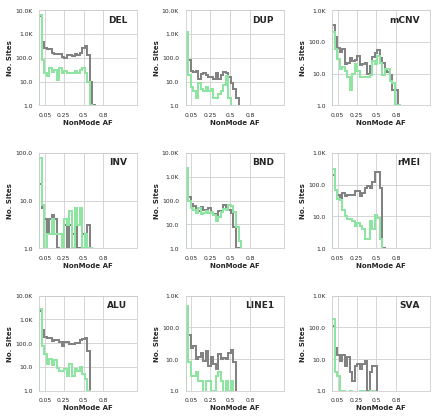

In [59]:
# fig =plt.figure(figsize=(7,7))


with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(3,3, figsize = (7,7), gridspec_kw={'wspace' : 0.5, 'hspace' :0.5}, sharex = True)
    # gs = mpl.gridspec.GridSpec(4, 4, 
    #                            figure =fig,
    #                            width_ratios=[1, 1], height_ratios = [0.8, 1, 0.8, 0.8], wspace = 0.5, hspace=0)

    count = 0
    af = axes.flat

    # af[0].get_shared_y_axes(af[0], af[2])

    bins = np.arange(0, 0.4, 0.01)
    for ind, svt in enumerate(order_sv_str[:-1]):
        ax = af[ind]

        tdf = info_nr[(info_nr.SVTYPE_all == svt)]
        tdf_known = tdf[tdf['novel'] =='Known']
        tdf_novel = tdf[tdf['novel'] == 'Novel']
         
        if tdf_known.shape[0] > 0:
            ax.hist(np.log10(tdf_known.NMODE_AF_unrel.astype(float) + 1), bins = bins, histtype = 'step', 
                     color = colors_known_novel['Known'], linewidth = 2, label = 'Known')
        if tdf_novel.shape[0] > 0:
            ax.hist(np.log10(tdf_novel.NMODE_AF_unrel.astype(float) + 1), bins = bins, histtype = 'step', 
                     color = colors_known_novel['Novel'], linewidth = 2, label = 'Novel')

        xlab = [0.05, 0.25, 0.5, 0.8]
        xticks = [np.log10(i + 1) for i in xlab]

        ax.set_xticks(xticks)
        ax.xaxis.set_tick_params(which = 'both', labelbottom = True)
        ax.set_xticklabels(xlab)

        ax.set_yscale('log')
        mpltools.fix_log_to_scalar_formatting(ax)
        yticklabs = mpltools.format_easy_read_log(ax.get_yticks())
        ax.set_yticklabels(yticklabs)
        ax.set_xlabel('NonMode AF')
        ax.set_ylabel("No. Sites")
        ax.text(0.9,0.9, svt, fontsize = 9, transform = ax.transAxes,
                horizontalalignment='right',  verticalalignment='center', weight = 'bold')

fig.savefig(os.path.join(private_out, 'SupFig_MAF_Dist_novel_Variants'), dpi=500, bbox_inches='tight') 